In [1]:
import numpy as np
import pytpc
import matplotlib.pyplot as plt
from pytpc.fitting.mcopt_wrapper import Tracker, EventGenerator, PadPlane, Minimizer
from pytpc.fitting.montecarlo import MCFitter
from pytpc.constants import *
from pytpc.cleaning import HoughCleaner
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import yaml
import math
from effsim.paramgen import uniform_param_generator
from effsim.effsim import EventSimulator
from scipy import interpolate

/home/chen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
with open('/home/chen/ar40/config/config_e15503a_runs_92-104.yml', 'r') as f:
    config = yaml.load(f)

mcfitter = MCFitter(config)

In [3]:
tilt = config['tilt'] * degrees 
padplane = mcfitter.padplane
efield = np.array(config['efield'])
bfield = np.array(config['bfield'])
mass_num = config['mass_num']
charge_num = config['charge_num']
gas = pytpc.gases.InterpolatedGas(config['gas_name'], config['gas_pressure'])
beam_enu0 = config['beam_enu0']
beam_charge = config['beam_charge']
beam_mass = config['beam_mass']
max_en = config['tracker_max_en']
vd = np.array(config['vd'])
max_beam_angle = (config['max_beam_angle']*math.pi)/180
beam_origin_z = config['beam_origin_z']
num_iters = config['num_iters']
num_pts = config['num_pts']
red_factor = config['red_factor']
clock = config['clock']
shape = config['shape']
pad_rot_angle = (config['pad_rot_angle']*math.pi)/180
electronics_gain = float(config['electronics_gain'])
micromegas_gain = float(config['micromegas_gain'])
diff_sigma = config['diffusion_sigma']
ioniz = 23.0 #eV

In [4]:
#Good events for run_0102 are: 689, 765, 896, 305, 504, 575, 456, 299, 399, 156, 231, 7832, 1568, 1354, 789, 485, 2456, 357, 4568, 1448, 3578, 745, 430, 1676, 811, 641, 871, 785, 37, 24, 75, 72, 35, 16, 12, 1718, 1, 9
full = h5py.File('/home/chen/ar40/config/clean_run_0102.h5', 'r')
evt_ID = 305
dataset_name = '/clean'
evt_full = full[dataset_name]
xyzs_h5 = evt_full[str(evt_ID)]
xyzs = np.array(xyzs_h5)

#delete the points which are farther away from the center of the spiral
del_list = []

DRIFT_VEL = 5.2
CLOCK = 12.5

for i in range(len(xyzs)):
    if (xyzs[i,6]) > 40.0:
        del_list.append(i)
    elif (xyzs[i][2])*CLOCK/DRIFT_VEL > 500.0:
        del_list.append(i)
    elif (xyzs[i][5] < 2.0): 
        del_list.append(i)         

cut_xyzs = np.delete(xyzs,del_list,axis=0)

print(xyzs[0])

[-1.45741499e+02  9.06868891e-01  1.86516085e+02  5.14131784e+02
  9.18200000e+03  4.00000000e+00  1.47813910e+01]


In [5]:
######finding center of curvature#######
xy = xyzs[:, 0:2]
xy_C = np.ascontiguousarray(xy, dtype=np.double)
cx, cy = pytpc.cleaning.hough_circle(xy_C)
print(cx,cy) #The center of curvature of the track, in mm.

cut_xy = cut_xyzs[:, 0:2]
cut_xy_C = np.ascontiguousarray(cut_xy, dtype=np.double)
cut_cx, cut_cy = pytpc.cleaning.hough_circle(cut_xy_C)

-43.91625428724363 9.816445862844423


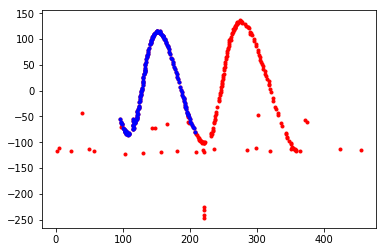

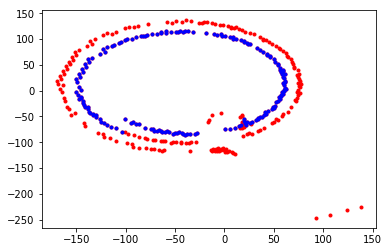

In [6]:
#######plotting real event#########
%matplotlib inline
plt.plot(xyzs[:, 2], xyzs[:, 1], 'r.')
plt.plot(cut_xyzs[:, 2], cut_xyzs[:, 1], 'b.')
plt.show()
plt.plot(xyzs[:, 0], xyzs[:, 1], 'r.')
plt.plot(cut_xyzs[:, 0], cut_xyzs[:, 1], 'b.')
plt.show()

In [7]:
uvw, (cu, cv) = mcfitter.preprocess(xyzs[:,0:5], center=(cx, cy), rotate_pads=False)
uvw_values = uvw.values #transform pd file to arrays
uvw_sorted = uvw.sort_values(by='w', ascending=True)
prefit_data = uvw_sorted.iloc[-len(uvw_sorted) // 4:].copy()
prefit_res = mcfitter.linear_prefit(prefit_data, cu, cv)
ctr0 = mcfitter.guess_parameters(prefit_res)
exp_pos = uvw_sorted[['u', 'v', 'w']].values.copy() / 1000
ctr0[4] += 2*pi
print(ctr0)

cut_uvw, (cut_cu, cut_cv) = mcfitter.preprocess(cut_xyzs[:,0:5], center=(cut_cx, cut_cy), rotate_pads=False)
cut_uvw_sorted = cut_uvw.sort_values(by='w', ascending=True)
cut_prefit_data = cut_uvw_sorted.iloc[-len(cut_uvw_sorted) // 4:].copy()
cut_prefit_res = mcfitter.linear_prefit(cut_prefit_data, cut_cu, cut_cv)
cut_ctr0 = mcfitter.guess_parameters(cut_prefit_res)
cut_exp_pos = cut_uvw_sorted[['u', 'v', 'w']].values.copy() / 1000
print(cut_ctr0)

[0.         0.         0.72005661 2.09442582 3.49679364 1.89956526]
[ 0.          0.          0.43940586  1.46760508 -2.7894479   1.90697197]


In [8]:
exp_hits = np.zeros(10240)
for a, p in uvw[['a', 'pad']].values:
    exp_hits[int(p)] = a
    
cut_exp_hits = np.zeros(10240)
for a, p in cut_uvw[['a', 'pad']].values:
    cut_exp_hits[int(p)] = a

In [9]:
sig = config['sigma']
reduction_factor = 0.8
##### get initial parameter space #####
sigma_init = np.array([sig['x'],sig['y'],sig['z'],sig['enu'],sig['azi']*math.pi/180,sig['pol']*math.pi/180])
##### set original candidate to be the seed point #####
candidate = ctr0

In [42]:
##### set original candidate to be the seed point #####
candidate = ctr0
####### generate a set of parameter vectors within given range #########
min_chi_value = []
min_chi_list = [sigma_init]
for i in range(10): ### number of iteration equals 20
    
    sigma = sigma_init*reduction_factor**float(i)
    num_events = 1000
    candidates = [sigma]
    print(candidate)
    while len(candidates) <= 501.0:
        pgen = uniform_param_generator(beam_enu0, beam_mass, beam_charge, mass_num, max_beam_angle,\
                                   beam_origin_z, gas, num_events)
        for evt in pgen:
            p = evt[0]
            try:
                if abs(p[0]-candidate[0]) >= sigma[0]:
                    raise ValueError
                elif abs(p[1]-candidate[1]) >= sigma[1]:
                    raise ValueError
                elif abs(p[2]-candidate[2]) >= sigma[2]:
                    raise ValueError
                elif abs(p[3]-candidate[3]) >= sigma[3]:
                    raise ValueError
                elif abs(p[4]-candidate[4]) >= sigma[4]:
                    raise ValueError
                elif abs(p[5]-candidate[5]) >= sigma[5]:
                    raise ValueError
            except ValueError:
                continue
            candidates = np.append(candidates, [p], axis=0)
    candidates = np.delete(candidates,0,0)

    print(i)
    print(candidates)
    print(len(candidates))
    
    ##### define variables #####
    sigmaPos = 5.0 ### in mm
    Poschi2 = np.empty((0,0))
    Poschi2_per_evt = np.empty((0,0))
    sigmaEng = 0.1
    sim = EventSimulator(config)
    chi2En_per_evt = 0.0
    hit_num = 0.0
    EngChi2 = np.empty((0,0))
    sigmaVert = 0.5e-4
    Chi2Vert_per_evt = 0.0
    VertChi2 = np.empty((0,0))
    
    for num in range(500):

        chi2Pos_x = np.empty((0,0))
        chi2Pos_y = np.empty((0,0))

        evtClean, ctr = sim.make_event(candidates[num][0], candidates[num][1], candidates[num][2], \
                                       candidates[num][3], candidates[num][4], candidates[num][5])
        pyevtClean = sim.convert_event(evtClean)
        sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, \
                                   baseline_correction=True, cg_times=True)

        ##### find energy chi2 #####

        hits = np.zeros(10240)
        for k, v in evtClean.items():
            hits[k] += v.max()

        sigmaEn = np.nanmax(exp_hits)*sigmaEng

        for p in range(10240):        
            if exp_hits[p] != 0:
                if np.isnan(exp_hits[p]) == False:
                    chi2En_per_evt += (float(exp_hits[int(p)])-float(hits[int(p)]))**2
                    hit_num += 1.0

        EngChi2 = np.append(EngChi2,chi2En_per_evt/sigmaEn**2/hit_num)

        ##### find Vertex chi2 #####

        Chi2Vert_per_evt = (candidates[num][0]**2 + candidates[num][1]**2)/sigmaVert
        VertChi2 = np.append(VertChi2,Chi2Vert_per_evt)

        f_x = interpolate.interp1d(sim_xyzs[:,2],sim_xyzs[:,0],bounds_error=False)
        f_y = interpolate.interp1d(sim_xyzs[:,2],sim_xyzs[:,1],bounds_error=False)

        ##### find position chi2 #####
        sim_x = f_x(xyzs[:,2])
        sim_y = f_y(xyzs[:,2])

        col_mean_x = np.nanmean(sim_x)
        inds_x = np.where(np.isnan(sim_x))
        sim_x[inds_x] = 0.0

        col_mean_y = np.nanmean(sim_y)
        inds_y = np.where(np.isnan(sim_y))
        sim_y[inds_y] = 0.0

        chi2Pos_x = np.append(chi2Pos_x,(sim_x-xyzs[:,0])/float(sigmaPos))    
        chi2Pos_y = np.append(chi2Pos_y,(sim_y-xyzs[:,1])/float(sigmaPos)) 
        Poschi2 = np.append(Poschi2,sum(chi2Pos_y**2+chi2Pos_x**2)/float(len(xyzs)))

        chi2En_per_evt = 0.0
        hit_num = 0.0

        Chi2Vert_per_evt = 0.0

    min_chi = min(Poschi2+EngChi2+VertChi2)
    print('minimum chi2:' + str(min_chi))
    min_chi_value.append(min_chi)
    for i in range(500):
        if abs(Poschi2[i]+EngChi2[i]+VertChi2[i]-min_chi) < 1.0:
            print(i)
            candidate = candidates[i]
            min_chi_list = np.append(min_chi_list,[candidate],axis=0)

min_chi_list = np.delete(min_chi_list,0,0)
print(min_chi_list)
for i in range(len(min_chi_value)):
    if min_chi_value[i] == min(min_chi_value):
        print(min_chi_list[i])

[0.         0.         0.72005661 2.09442582 3.49679364 1.89956526]


/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/relativity.py:66: RuntimeWarning: invalid value encountered in sqrt
  pcm = np.sqrt(((s - m1**2 - m2**2)**2 - 4 * m1**2 * m2**2) / (4 * s))
/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/relativity.py:67: RuntimeWarning: invalid value encountered in sqrt
  ppcm = np.sqrt(((s - m3**2 - m4**2)**2 - 4 * m3**2 * m4**2) / (4 * s))


0
[[-8.64571027e-03 -6.81990025e-03  7.30144191e-01  1.36345141e+00
   3.97797890e+00  1.88890087e+00]
 [-4.27365512e-04  1.26012858e-02  6.37426875e-01  5.76808894e-01
   3.39317289e+00  1.81268427e+00]
 [-2.97355664e-03 -6.62209387e-03  6.90344362e-01  5.75539857e+00
   2.88333782e+00  2.35971209e+00]
 ...
 [-8.03007060e-03  4.20048848e-03  7.07205870e-01  4.44468251e+00
   3.68083874e+00  2.22668055e+00]
 [ 1.26768704e-02  4.04697228e-03  6.73833509e-01  5.94908176e+00
   3.63214689e+00  2.41936459e+00]
 [ 3.92262548e-03  1.30771892e-02  6.59019122e-01  6.12245463e-01
   2.52021861e+00  1.80145500e+00]]
533


/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)
/home/chen/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/home/chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:88: RuntimeWarning: Mean of empty slice
/home/chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: Mean of empty slice


minimum chi2:358.67282241277826
361
[0.00574434 0.00905808 0.77798997 1.97748039 2.97620679 1.98880756]
1
[[-4.60467652e-03  6.43205663e-03  7.39361660e-01  3.91972498e+00
   2.52925980e+00  2.15757727e+00]
 [-8.35132235e-03 -3.71475331e-03  7.77484822e-01  2.09720994e+00
   3.42422677e+00  1.96512160e+00]
 [-1.61487995e-03  1.83287469e-03  8.36100705e-01  4.30029031e+00
   3.42788063e+00  2.16675539e+00]
 ...
 [ 8.78260699e-03 -1.75287594e-03  7.71986964e-01  2.04871904e+00
   2.50755623e+00  2.00839461e+00]
 [ 4.47867457e-03  9.20433007e-03  7.25823284e-01  4.17962501e+00
   3.09638683e+00  2.21506634e+00]
 [ 1.27599889e-02 -5.65509026e-03  7.08975622e-01  7.28556155e-01
   2.23754023e+00  1.85246705e+00]]
517
minimum chi2:200.0812755955216
16
[4.41506621e-03 1.91109537e-03 8.24258958e-01 2.38946794e+00
 2.80142702e+00 2.01913227e+00]
2
[[-2.03453535e-03  8.80496106e-04  8.09021489e-01  1.96055360e+00
   2.75545289e+00  1.96115717e+00]
 [-2.25975678e-04 -8.33992711e-03  8.24370801e-0

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/relativity.py:75: RuntimeWarning: invalid value encountered in sqrt
  root = np.sqrt(coshx**2 * (E3cm**2 + m3**2 * (-coshx**2 + np.cos(th3)**2 * sinhx**2)))


8
[[-3.25209948e-03 -1.08652559e-03  8.21412932e-01  2.39436991e+00
   3.00275694e+00  1.99950489e+00]
 [ 7.27494414e-03 -2.89847891e-03  8.31845979e-01  2.14849885e+00
   3.00293070e+00  2.00684225e+00]
 [-4.06088726e-03 -6.22358335e-04  8.29331050e-01  2.35514638e+00
   2.87627344e+00  1.99124894e+00]
 ...
 [ 6.75468677e-03  3.72815752e-03  8.26367488e-01  2.60944240e+00
   2.77090077e+00  2.04436547e+00]
 [ 6.90090032e-03  6.31958859e-03  8.36599113e-01  2.86183736e+00
   2.85306324e+00  2.06513097e+00]
 [-6.03439110e-04 -2.44922719e-03  8.46252511e-01  3.04423898e+00
   2.78872417e+00  2.06362738e+00]]
501
minimum chi2:159.77011488111805
93
[-0.00629694  0.0047183   0.8332023   2.59241746  2.79235368  2.00059754]


KeyboardInterrupt: 

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


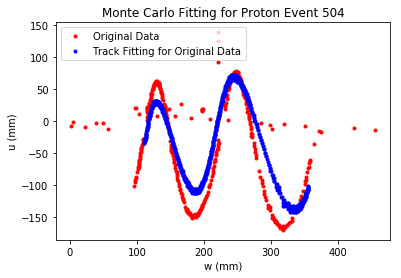

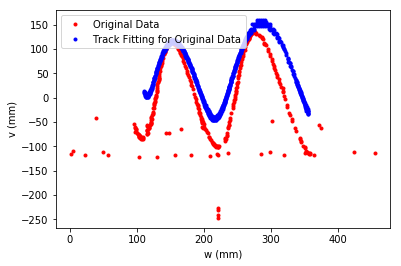

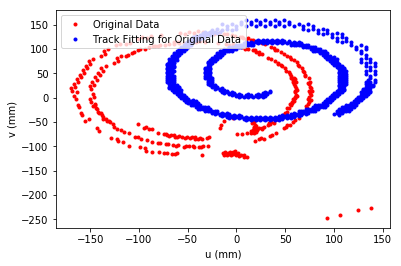

In [56]:
%matplotlib inline
mcres = [1.28876647e-02,-3.25318790e-03,7.10291285e-01,2.11052342e+00,3.63722882e+00,2.03325428e+00]
#mcres =[-0.00629694,0.0047183,0.8332023,2.59241746,2.79235368,2.00059754]

sim = EventSimulator(config)
evtClean, ctr = sim.make_event(mcres[0], mcres[1], mcres[2], mcres[3], mcres[4], mcres[5])
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values
plt.plot(xyzs[:, 2], xyzs[:, 0], 'r.', label='Original Data')
plt.plot(sim_xyzs[:, 2], -sim_xyzs[:, 0], 'b.', label='Track Fitting for Original Data')
#plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.', label='Original Data')
#plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.', label='Track Fitting for Original Data')
plt.xlabel("w (mm)")
plt.ylabel("u (mm)")
plt.title("Monte Carlo Fitting for Proton Event 504")
plt.legend(loc=2)
plt.show()
plt.plot(xyzs[:, 2], xyzs[:, 1], 'r.', label='Original Data')
plt.plot(sim_xyzs[:, 2], -sim_xyzs[:, 1], 'b.', label='Track Fitting for Original Data')
#plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.', label='Original Data')
#plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.', label='Track Fitting for Original Data')
plt.xlabel("w (mm)")
plt.ylabel("v (mm)")
plt.legend(loc=2)
plt.show()
plt.plot(xyzs[:, 0], xyzs[:, 1], 'r.', label='Original Data')
plt.plot(sim_xyzs[:, 0], -sim_xyzs[:, 1], 'b.', label='Track Fitting for Original Data')
#plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.', label='Original Data')
#plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.', label='Track Fitting for Original Data')
plt.xlabel("u (mm)")
plt.ylabel("v (mm)")
plt.legend(loc=2)
plt.show()

In [45]:
##### set original candidate to be the seed point #####
candidate = ctr0
min_chi_value = []
min_chi_list = [sigma_init]
for i in range(10): ### number of iteration equals 20

    sigma = sigma_init*reduction_factor**float(i)
    num_events = 1000
    candidates = [sigma]
    print(candidate)
    while len(candidates) <= 501.0:
        pgen = uniform_param_generator(beam_enu0, beam_mass, beam_charge, mass_num, max_beam_angle,\
                                   beam_origin_z, gas, num_events)
        for evt in pgen:
            p = evt[0]
            try:
                if abs(p[0]-candidate[0]) >= sigma[0]:
                    raise ValueError
                elif abs(p[1]-candidate[1]) >= sigma[1]:
                    raise ValueError
                elif abs(p[2]-candidate[2]) >= sigma[2]:
                    raise ValueError
                elif abs(p[3]-candidate[3]) >= sigma[3]:
                    raise ValueError
                elif abs(p[4]-candidate[4]) >= sigma[4]:
                    raise ValueError
                elif abs(p[5]-candidate[5]) >= sigma[5]:
                    raise ValueError
            except ValueError:
                continue
            candidates = np.append(candidates, [p], axis=0)
    candidates = np.delete(candidates,0,0)

    print(i)

    Poschi2 = np.empty((0,0))
    Poschi2_per_evt = np.empty((0,0))
    sim = EventSimulator(config)
    chi2En_per_evt = 0.0
    hit_num = 0.0
    EngChi2 = np.empty((0,0))
    sigmaVert = 0.5e-4
    Chi2Vert_per_evt = 0.0
    VertChi2 = np.empty((0,0))

    for num in range(500):

        evtClean, ctr = sim.make_event(candidates[num][0], candidates[num][1], candidates[num][2], \
                                       candidates[num][3], candidates[num][4], candidates[num][5])
        pyevtClean = sim.convert_event(evtClean)
        sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, \
                                   baseline_correction=True, cg_times=True)

        ##### find energy chi2 #####
        hits = np.zeros(10240)
        for k, v in evtClean.items():
            hits[k] += v.max()

        for p in range(10240):        
            if exp_hits[p] != 0:
                if np.isnan(exp_hits[p]) == False:
                    chi2En_per_evt += (1.0-float(hits[int(p)])/float(exp_hits[int(p)]))**2
                    hit_num += 1.0

        EngChi2 = np.append(EngChi2,chi2En_per_evt/hit_num)

        ##### find vertex chi2 #####
        Chi2Vert_per_evt = (candidates[num][0]**2 + candidates[num][1]**2)/sigmaVert
        VertChi2 = np.append(VertChi2,Chi2Vert_per_evt)

        ##### find position chi2 #####
        f_x = interpolate.interp1d(sim_xyzs[:,2],sim_xyzs[:,0],bounds_error=False)
        f_y = interpolate.interp1d(sim_xyzs[:,2],sim_xyzs[:,1],bounds_error=False)

        sim_x = f_x(xyzs[:,2])
        sim_y = f_y(xyzs[:,2])

        col_mean_x = np.nanmean(sim_x)
        inds_x = np.where(np.isnan(sim_x)) #array with all the indicies that have a Nan
        sim_x[inds_x] = 1000.0

        col_mean_y = np.nanmean(sim_y)
        inds_y = np.where(np.isnan(sim_y)) #array with all the indicies that have a Nan
        sim_y[inds_y] = 1000.0

        Poschi2_per_evt = np.append(Poschi2_per_evt, sum((1.0-sim_x/xyzs[:,0])**2+(1.0-sim_y/xyzs[:,1])**2))
        Poschi2 = np.append(Poschi2, Poschi2_per_evt/float(len(xyzs))/2.0)
        Poschi2_per_evt = np.empty((0,0))
        
#        for i in range(len(xyzs)):
#            if np.isnan(sim_x[i]) == False:
#                if np.isnan(sim_y[i]) == False:
#                    Poschi2_per_evt = np.append(Poschi2_per_evt, (1.0-sim_x[i]/xyzs[i,0])**2+(1.0-sim_y[i]/xyzs[i,1])**2)
#        try:
#            Poschi2 = np.append(Poschi2, sum(Poschi2_per_evt)/float(len(Poschi2_per_evt))/2.0)
#        except Exception:
#            Poschi2 = np.append(Poschi2, 1e3)
        
        Poschi2_per_evt = np.empty((0,0))
        chi2En_per_evt = 0.0
        Chi2Vert_per_evt = 0.0
        
    print(Poschi2)
    
    min_chi = min(Poschi2+EngChi2+VertChi2)
    print('minimum chi2:' + str(min_chi))
    min_chi_value.append(min_chi)
    
    for i in range(500):
        if abs(Poschi2[i]+EngChi2[i]+VertChi2[i]-min_chi) < 1.0e-5:
            print(i)
            candidate = candidates[i]
            min_chi_list = np.append(min_chi_list,[candidate],axis=0)

min_chi_list = np.delete(min_chi_list,0,0)
print(min_chi_list)
for i in range(len(min_chi_value)):
    if min_chi_value[i] == min(min_chi_value):
        print(min_chi_list[i])

[0.         0.         0.72005661 2.09442582 3.49679364 1.89956526]


/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/relativity.py:66: RuntimeWarning: invalid value encountered in sqrt
  pcm = np.sqrt(((s - m1**2 - m2**2)**2 - 4 * m1**2 * m2**2) / (4 * s))
/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/relativity.py:67: RuntimeWarning: invalid value encountered in sqrt
  ppcm = np.sqrt(((s - m3**2 - m4**2)**2 - 4 * m3**2 * m4**2) / (4 * s))


0


/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)
/home/chen/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/home/chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice
/home/chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice


[ 951.04569206 5547.25333283 2796.49805901 2181.57771033 1323.25253077
 1985.16097992 1983.18928239  437.20096147 4999.90780461 1981.39836232
 3020.24823906 1976.97027876 2002.47102243 2390.58148959 2002.27254891
 3929.33438044 1424.95349636 1873.12743885 2732.89434966 2145.83697456
 1983.30786521 2035.2400874  2355.49067857 1978.52955349 1980.50709987
 1982.78467222 2164.92247676 1970.05657518 1229.18937073 1218.1290297
 2421.13605853 3094.12044187 1295.18522899 1983.1030059  1983.20729158
 1983.56550255 1979.99967898 2043.0006585  2229.5683061  1986.24357631
 1422.13026047 3012.46694136 2556.96000169 1983.18701838 2088.1655149
 2523.50261439 1796.84662376 2146.86098188 2593.13813351 1018.03190705
 1676.63991261 1612.42220679 1983.4450891  1961.60244007 2065.53180498
 1253.4550871  1242.44634874 2347.32832991 5921.92673324 1962.47569427
 3017.67842362 1265.74535242 1984.16332618 2015.48686706 2447.98204735
 1983.28082855 1981.88638789 2040.33810669 4350.64501802 1983.06095852
 1963.95

2
[  76.77394133  648.79595323 2971.52253805  934.3223783  1183.99567032
 2339.47956518 1960.12823434 2099.83947991 2113.0235325   426.89197992
 1981.16778709 2010.96416331 2805.09380434 1983.50608248 1983.03466848
 1871.354446   2677.94301583 1978.31530367 1540.50619375 1397.244637
 1983.1612077   817.44674709 1413.48361036 3010.20120805  279.16003535
 1981.93188849 3516.24791017  189.91920969  679.64625684 1787.33580484
 1449.33826932 2767.49830838 1562.34121552 1983.26765767 1983.83489169
 2025.0202304  1983.15247652 1982.95888409 2315.99293254 1099.03432349
 1979.66637894 1980.20669122  491.82992419 1978.26905285 1209.38422676
 1985.27889346 2591.96700299 1979.21085815 1980.57866373 1983.14489939
 1219.0358808  1981.42278544 1983.8097671  2247.03638568 1529.13609264
 1569.01999118 1983.13987048 1493.82921263 4265.74138204 2804.81292491
 1980.32025388 3148.04651241 1984.03022239 1883.91773457 1980.37086965
  158.94694223 2879.82182338 2447.43290586 1825.54557082  219.6423399
 1981.0

4
[1007.87611941 2448.99469016 1003.84258558  385.83681703 1663.04410144
 1981.41853113 2321.82854973 2109.78613923 1972.91920626 1969.53773675
 1963.52152862 1980.57693382 3127.38721046 1969.89723249  286.9215249
  393.13590147  588.27699311 1963.93963817 1981.27413436 3046.41973299
 1576.21336061 2507.96261815 1981.96517653  515.87463714 1189.98556373
 1980.91369936 1638.89377922 2640.7053119  1962.3744026  1978.1454688
 1961.2738753  1057.35108384 1980.64115844 2793.28243743  195.59872873
 1251.21446953 1503.53248155 1615.06965102 1975.37121314 1671.73889373
 1981.35794674 2401.68685063 1980.49813146 1978.55326104  105.2102628
 1982.08567558  916.62122313 1975.24983416 1159.90069788 1980.07507805
  743.29078618 1974.57028704  142.28082859 2434.66197703 2072.93492401
 1981.76133237 2388.18812017 1037.08338422 1978.47136725 1982.07177291
 1784.13401315  902.45922711 1847.30626898 1251.15521558 1687.08950733
 1698.31806017 2427.29944706 1979.38716395 1403.91104855 2152.7143668
 3009.29

6
[1967.52132953  152.91910358 1687.84836795  863.97819372  575.47397771
  431.48543106 2031.4804491   405.89620682 1205.78007252 1982.71760854
 1939.04029207  331.47201613 2925.24802182  620.00898978 2191.91067086
 2163.18589954 2118.1395397  1976.83373991 1211.82382611 1943.99205872
 1034.52552981  500.6900952   608.00642298 2034.47566234 1967.55193258
 1543.99045755 1975.37747668 1978.19696687 1984.69374765 2065.52946874
 1727.72108681 1978.53587413 1448.51871375  593.80949987 1983.6788209
 1553.55201626 1147.69119496 1986.32832428 2176.5121483  1401.82204676
 1210.27264622  818.46748111   67.27050585 1985.30716348 2209.16944151
 1163.45256292 1511.05807204 1974.5983225  1983.70863162 2038.50698487
 2171.54643454 2145.96706457 2272.80053307 1699.27163847 1824.30215517
 1931.16136027  829.97021668  764.59163949 1983.34753213  310.41910064
 2063.05955375 1955.3619194   586.33309914 1983.50113862 1232.84415757
  231.8842777  2076.37114419 1327.55153937 1955.14993604  674.65146107
 1018

KeyboardInterrupt: 

In [23]:
x = np.array([1,2,3])
y = np.array([1,1,1])
z = 1.0-x/y
print(z**2)

[0. 1. 4.]
